# Start of the lab 03
#### By Haeffner Edwin and Junod Arthur

## Concatenation of the two dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

mice_eeg1 = pd.read_csv('./pw3_data/EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('./pw3_data/EEG_mouse_data_2.csv')

mice_eeg = pd.concat([mice_eeg1, mice_eeg2], axis=0)

# Select the first 25 amplitudes as they are the most interesting
mice_eeg = mice_eeg.iloc[:, :26]

## KFold grouping

In [2]:
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

output_data = []

pl.clf()


keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(mice_eeg)):
    scaler = StandardScaler()
    
    # Select the training and test data
    train_data = mice_eeg.iloc[train_index]
    test_data = mice_eeg.iloc[test_index]
    
    train_numeric_columns = train_data.columns[1:]
    
    # Fit the scaler on the training data and transform both training and test data
    train_numeric_values = scaler.fit_transform(train_data.loc[:, train_numeric_columns])
    
    # Convert the transformed data back to a DataFrame
    train_data.loc[:, train_numeric_columns] = train_numeric_values
    
    # Now you can print the transformed train_data
    print(train_data)
    

2024-03-22 15:41:21.743640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


      state  amplitude_around_1_Hertz  amplitude_around_2_Hertz  \
0         n                 -0.208032                 -0.084971   
2         n                 -0.143098                  3.647342   
3         w                 -0.435617                  0.935007   
4         w                 -0.186212                 -0.240048   
5         w                  0.012680                 -0.162101   
...     ...                       ...                       ...   
20600     w                  0.387854                 -0.465343   
20601     w                  0.082683                  1.379755   
20602     w                  0.064987                  0.791565   
20603     w                 -0.064123                 -0.088293   
20604     w                 -0.422924                 -0.545588   

       amplitude_around_3_Hertz  amplitude_around_4_Hertz  \
0                     -0.106292                 -0.028809   
2                      1.390951                  0.313159   
3           

<Figure size 640x480 with 0 Axes>

## Data normalization

In [3]:
def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(25),
      layers.Dense(32, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(32, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.8),
      loss="mse",
  )

  return mlp

mlp = create_model()
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
Total params: 1,888
Trainable params: 1,888
Non-trainable params: 0
_________________________________________________________________


2024-03-22 15:41:25.597695: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode the states into asleep (-1) and awake (1)


history_list = []
trained_mlp = []

mice_eeg = np.array(mice_eeg)


input_data = mice_eeg[:,1:26].astype('float64')
output_data = mice_eeg[:,1]

output_data[output_data == 'w'] = 1.
output_data[output_data == 'n'] = -1.
output_data[output_data == 'r'] = -1.

output_data = output_data.astype('float32')


for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    scaler = StandardScaler()
    # We need to create a new model everytime otherwise fit will continue previous training
    mlp = create_model()
    
    history = mlp.fit(
        x=scaler.fit_transform(input_data[train_index]), y=output_data[train_index],
        validation_data=(scaler.transform(input_data[test_index]), output_data[test_index]),
        epochs=10
    )

history_list.append(history)
trained_mlp.append(mlp)
    

Epoch 1/10
852/852 [==============================] - 8s 8ms/step - loss: 0.1888 - val_loss: 0.1633
Epoch 2/10
852/852 [==============================] - 7s 9ms/step - loss: 0.1448 - val_loss: 0.1280
Epoch 3/10
852/852 [==============================] - 6s 7ms/step - loss: 0.1148 - val_loss: 0.1022
Epoch 4/10
852/852 [==============================] - 5s 6ms/step - loss: 0.0920 - val_loss: 0.0822
Epoch 5/10
852/852 [==============================] - 4s 5ms/step - loss: 0.0742 - val_loss: 0.0666
Epoch 6/10
852/852 [==============================] - 5s 6ms/step - loss: 0.0602 - val_loss: 0.0544
Epoch 7/10
852/852 [==============================] - 6s 7ms/step - loss: 0.0494 - val_loss: 0.0449
Epoch 8/10
852/852 [==============================] - 6s 7ms/step - loss: 0.0410 - val_loss: 0.0374
Epoch 9/10
852/852 [==============================] - 7s 9ms/step - loss: 0.0344 - val_loss: 0.0316
Epoch 10/10
852/852 [==============================] - 4s 5ms/step - loss: 0.0292 - val_loss: 0.0271

## Plotting the training history

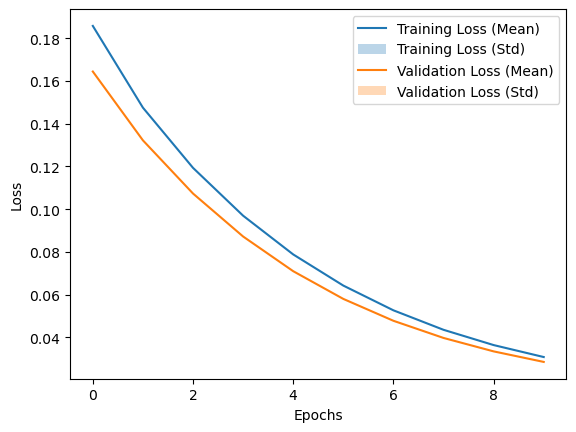

In [5]:
train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()